In [838]:
from importlib import reload
import glob
import sys
sys.path.insert(0, '../scripts/')
import get_bounding_boxes_from_html as bb
import os 
from playwright.async_api import async_playwright
import scrape_using_wget as s
import math
from tqdm.auto import tqdm
import pandas as pd
import seaborn as sns
import numpy as np 
import matplotlib.pyplot as plt 
here = os.getcwd()

In [839]:
wayback_scrape_dir = '../data/web.archive.org/'
inquirer_files = glob.glob(
    wayback_scrape_dir + '/web/*[!_]/inquirer.com/*'
)

inquirer_files = sorted(inquirer_files, key=lambda x: x.split('/')[-3])
# bounding_box_dfs, all_height_width = await bb.get_bounding_boxes_for_files(
#     nyt_files, here=here, headless=True
# )

In [840]:
page, browser, playwright = await bb.instantiate_new_page_object(headless=False, block_external_files=False)

/Users/spangher/Projects/usc-research/newsworthiness/notebooks/../scripts/get_bounding_boxes_from_html.py:486: RuntimeWarning: coroutine 'Browser.new_context' was never awaited
  browser.new_context(screen={'width': 860, 'height': 2040})


In [95]:
one_file = inquirer_files[0]
fp = os.path.join(here, one_file)
file = f'file://{fp}'

await page.goto(file, timeout=0)

<Response url='file:///Users/spangher/Projects/usc-research/newsworthiness/data/web.archive.org//web/20221201001539/inquirer.com/index.html' request=<Request url='file:///Users/spangher/Projects/usc-research/newsworthiness/data/web.archive.org//web/20221201001539/inquirer.com/index.html' method='GET'>>

In [96]:
bounding_boxes, _ = await bb.get_bounding_boxes_for_files(
    inquirer_files, 
)

  0%|          | 0/569 [00:00<?, ?it/s]

In [97]:
bounding_boxes = list(filter(lambda x: len(x) > 0, bounding_boxes))

In [108]:
idx = 6
merged_bb, bb_1, bb_2 = bb.merge_and_dedupe_bbs(bounding_boxes[idx], bounding_boxes[idx+1])

In [ ]:
# resize by bands

In [ ]:
band_start_stops = []
for bb_df in tqdm(bounding_boxes[len(band_start_stops):]):
    try:
        bb_df['bands'] = bb_df.pipe(bb.get_bands_for_each_article)
        one_df_start_stop = bb.get_min_max_height_for_each_band(bb_df)
        band_start_stops.append(one_df_start_stop)
    except Exception as e:
        print(f'failed on {str(e)}')
        continue

In [ ]:
num_banding_patterns = list(set(map(lambda x: x.shape[0], band_start_stops)))
pd.Series(map(lambda x: x.shape[0], band_start_stops)).value_counts()

In [140]:
mean_start_stops = {
    i: bb.get_mean_start_stops_shifted(i, band_start_stops) 
    for i in num_banding_patterns
}

In [143]:
squeezed_bb_dfs = []
for bb_df in tqdm(bounding_boxes):
    try:
        if 'bands' not in bb_df:
            bb_df['bands'] = bb.get_bands_for_each_article(bb_df)
        t = bb.resize_bb_df_by_bands(bb_df, mean_start_stops)
        squeezed_bb_dfs.append(t)
    except Exception as e:
        print( f'failed on {str(e)}')
        continue

  0%|          | 0/558 [00:00<?, ?it/s]

/Users/spangher/Projects/usc-research/newsworthiness/notebooks/../scripts/get_bounding_boxes_from_html.py:668: RuntimeWarning: invalid value encountered in double_scalars
  x_bins = np.arange(0, max_width + x_step, x_step)


In [369]:
df_list = bounding_boxes
idx = 5
merged_bb, bb_1, bb_2 = bb.merge_and_dedupe_bbs(df_list[idx], df_list[idx+1])

In [456]:
merged_bb = (
    merged_bb
    .assign(delta_y=lambda df: df['midpoint_y_y'] - df['midpoint_y_x'])
    .assign(delta_y_adj = np.nan)
)

global_min_x_bin, global_max_x_bin = 0, 4
global_min_y_bin, global_max_y_bin = 0, 10

for idx in merged_bb.index:
    bin_x_x = merged_bb.loc[idx, 'bin_x_x']
    bin_y_x = merged_bb.loc[idx, 'bin_y_x']

    min_x_bin, max_x_bin = max( bin_x_x - 1, global_min_x_bin), min( bin_x_x + 1, global_max_x_bin)
    min_y_bin, max_y_bin = max( bin_y_x - 1, global_min_y_bin), min( bin_y_x + 1, global_max_y_bin)


    y_corrective = (merged_bb
         .loc[lambda df: (df['bin_x_x'] >= min_x_bin) & (df['bin_x_x'] <= max_x_bin)]
         .loc[lambda df: (df['bin_y_x'] >= min_y_bin) & (df['bin_y_x'] <= max_y_bin)] 
         ['delta_y']
         .quantile([.1, .2, .3, .4, .5, .6, .7, .8, .9]).mean()
    )

    direction = math.copysign(1, y_corrective)
    thresholded_val = min(abs(y_corrective), merged_bb['page_height_x'].iloc[0] / 10)
    y_corrective = direction * thresholded_val

    merged_bb.at[idx, 'delta_y_adj'] = merged_bb.loc[idx, 'delta_y'] - y_corrective

In [478]:
up, down = bb.get_upwards_and_downwards_articles_one_df(merged_bb, movement_threshold=.05)

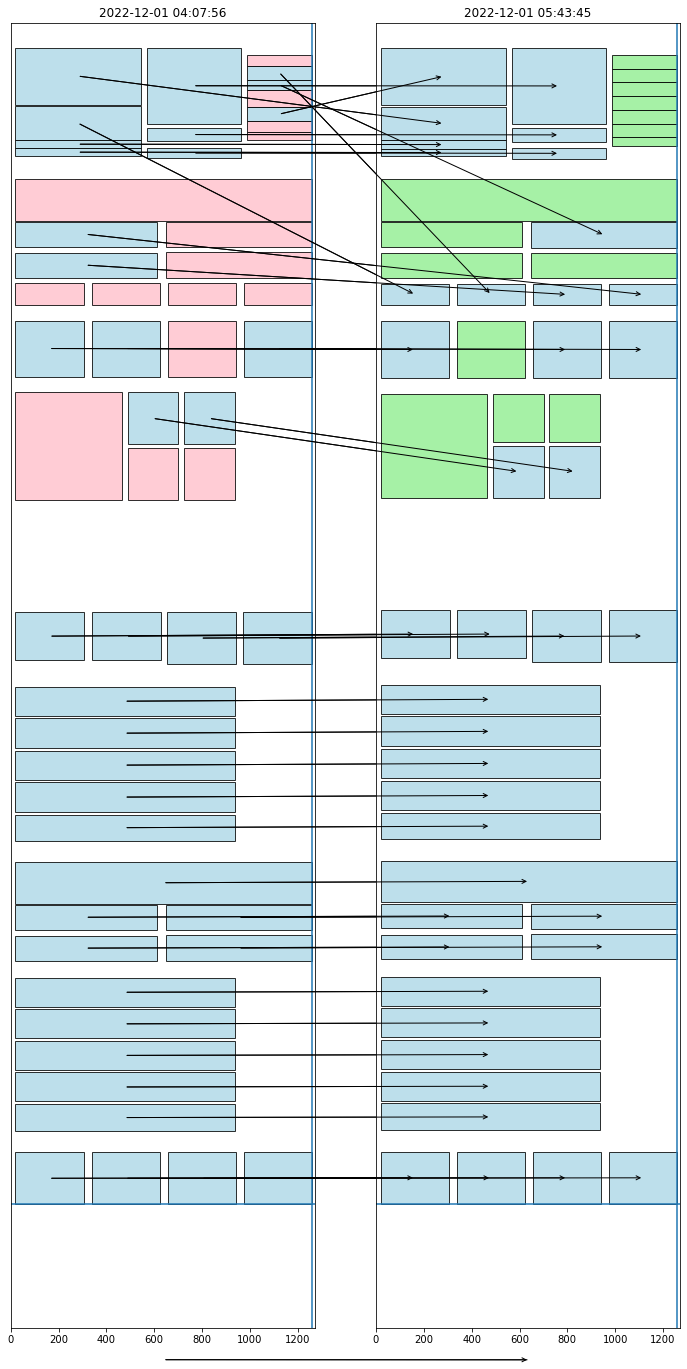

In [458]:
bb.plot_merged_df(merged_bb, bb_1, bb_2)

In [226]:
width_steps = np.arange(0, page_width, step=int(page_width / 4)).astype(int)
height_steps = np.arange(0, page_height, step=int(page_height / 10)).astype(int)

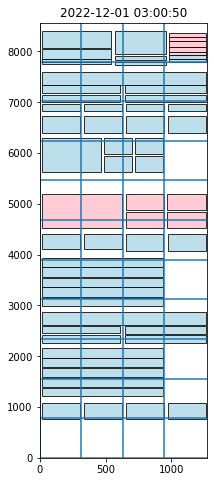

In [230]:
_, ax = plt.subplots(1, 1, figsize=(3, 8))
bb.plot_bounding_box_df(bb_1, clip_right=True, ax= ax)

xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()

for yline in height_steps:
    ax.hlines(yline, xmin, xmax)
for xline in width_steps:
    ax.vlines(xline, ymin, ymax)

In [388]:
homepage_grids = []
for bb_df in tqdm(bounding_boxes):
    g = bb.get_coarsified_layout_grid(
        bb_df, clip_x=True, use_perc=True, max_count=1
    )
    homepage_grids.append(g)

  0%|          | 0/558 [00:00<?, ?it/s]

In [433]:
mean_homepage_grids = sum(homepage_grids) / len(homepage_grids)

add_del_bb_dfs, all_merged_bb_dfs = bb.get_pairwise_add_del_and_merge_dfs(bounding_boxes)
added_grids, deleted_grids = bb.get_added_and_deleted_grids(add_del_bb_dfs)

In [481]:
all_upwards_boxes, all_downwards_boxes = bb.get_upwards_and_downwards_articles(
    all_merged_bb_dfs, use_width_in_df=False, use_height_in_df=False, move_threshold=.05
)
upwards_grids, downwards_grids = bb.get_upwards_and_downwards_grids(all_upwards_boxes, all_downwards_boxes)

  0%|          | 0/557 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

In [482]:
mean_added = sum(added_grids) / len(added_grids)
mean_deleted = sum(deleted_grids) / len(deleted_grids)

In [483]:
mean_upwards = sum(upwards_grids) / len(upwards_grids)
mean_downwards = sum(downwards_grids) / len(downwards_grids)

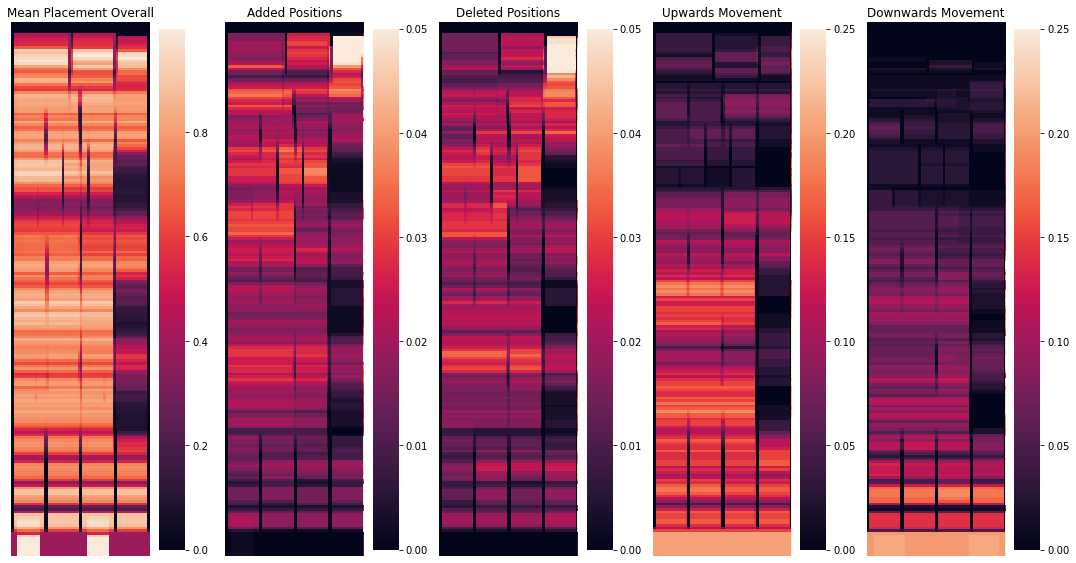

In [485]:
_, axarr = plt.subplots(1, 5, figsize=(15, 8))

ax = sns.heatmap(mean_homepage_grids, ax=axarr[0])
ax.set_xticks([]), ax.set_yticks([])
ax.set_title('Mean Placement Overall');

ax = sns.heatmap(mean_added, vmax=.05, ax=axarr[1])
ax.set_xticks([]), ax.set_yticks([])
ax.set_title('Added Positions') ;

ax = sns.heatmap(mean_deleted, ax=axarr[2], vmax=.05)
ax.set_xticks([]), ax.set_yticks([])
ax.set_title('Deleted Positions') ;

ax = sns.heatmap(mean_upwards, ax=axarr[3], vmax=.25)
ax.set_xticks([]), ax.set_yticks([])
ax.set_title('Upwards Movement') ;

ax = sns.heatmap(mean_downwards, ax=axarr[4], vmax=.25)
ax.set_xticks([]), ax.set_yticks([])
ax.set_title('Downwards Movement') ;

plt.tight_layout()

In [531]:
def all_consecutive_lens(arr):
    output = []
    curr_count = 0
    for i in arr:
        if i:
            curr_count += 1
        else:
            output.append(curr_count)
            curr_count = 0
    return output

In [487]:
homepage_url_grids = []
for bb_df in tqdm(bounding_boxes):
    g = bb.get_coarsified_layout_grid(
        bb_df, clip_x=True, use_perc=True, fill_with_ones=False
    )
    homepage_url_grids.append(g)

  0%|          | 0/558 [00:00<?, ?it/s]

In [573]:
pairwise_matching = []
for h_x, h_y in zip(homepage_url_grids[:-1], homepage_url_grids[1:]):
    pairwise_matching.append(h_x == h_y)

In [574]:
mean_pairwise_matching = sum(pairwise_matching) / len(pairwise_matching)

consecutive_article_lengths = (
    pd.concat(pairwise_matching)
         .groupby(level=0)
         .aggregate(list)
         .applymap(all_consecutive_lens)
)

mean_consecutive_article = consecutive_article_lengths.applymap(lambda x: sum(x) / len(x))

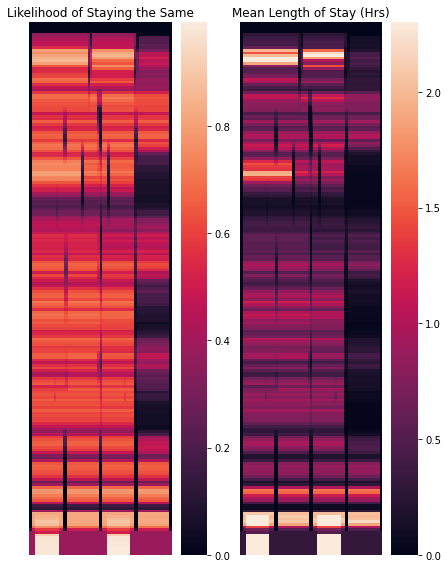

In [577]:
_, axarr = plt.subplots(1, 2, figsize=(6, 8))
ax = sns.heatmap(mean_pairwise_matching, ax=axarr[0], )
ax.set_xticks([]), ax.set_yticks([])
ax.set_title('Likelihood of Staying the Same') ;

ax = sns.heatmap(mean_consecutive_article * .5, ax=axarr[1], vmax=2.3)
ax.set_xticks([]), ax.set_yticks([])
ax.set_title('Mean Length of Stay (Hrs)') ;
plt.tight_layout()

In [582]:
t = bounding_boxes[0]['href'][0]

In [589]:
all_inquirer_urls = pd.concat(bounding_boxes)['href'].value_counts()

In [597]:
unique_inquirer_urls = (all_inquirer_urls
 .pipe(lambda s: s/len(bounding_boxes))
 .loc[lambda s: s<.5]
 .index.tolist()
)

In [602]:
wayback_urls = {}
for url in tqdm(unique_inquirer_urls):
    num_entries_in_wayback = ! waybackpack $url  --list
    wayback_urls[url] = num_entries_in_wayback

  0%|          | 0/1073 [00:00<?, ?it/s]

In [606]:
pd.Series(wayback_urls).str.len().value_counts().sort_index()

1      102
2      356
3      212
4      101
5       63
6       57
7       34
8       41
9       17
10      24
11       7
12       7
13      15
14       3
15       3
16       3
17       1
18       1
19       4
20       2
21       3
22       1
24       1
27       2
28       1
30       2
32       2
34       1
35       1
44       1
45       1
50       1
57       1
62       1
256      1
dtype: int64

In [623]:
pd.Series(wayback_urls).str.get(-1)[0]

'https://web.archive.org/web/20230214071943/https://www.inquirer.com/politics/pennsylvania/josh-shapiro-pa-governor-bipartisanship-20221226.html'

In [624]:
import newspaper

In [627]:
from newspaper import Article

url = 'http://fox13now.com/2013/12/30/new-year-new-laws-obamacare-pot-guns-and-drones/'
article = Article(url)

In [629]:
article = Article(unique_inquirer_urls[0])

In [630]:
article.download()

In [638]:
article.parse()

# LATimes

In [673]:
wayback_scrape_dir = '../data/web.archive.org'
latimes_files = glob.glob(
    wayback_scrape_dir + '/web/*[!_]/latimes.com/*'
)


latimes_files = sorted(latimes_files, key=lambda x: x.split('/')[-3])
# bounding_box_dfs, all_height_width = await bb.get_bounding_boxes_for_files(
#     nyt_files, here=here, headless=True
# )

In [714]:
page, browser, playwright = await bb.instantiate_new_page_object(headless=False, block_external_files=False)

/Users/spangher/Projects/usc-research/newsworthiness/notebooks/../scripts/get_bounding_boxes_from_html.py:481: RuntimeWarning: coroutine 'Browser.new_context' was never awaited
  browser.new_context(screen={'width': 860, 'height': 2040})


In [730]:
one_file = latimes_files[10]
fp = os.path.join(here, one_file)
file = f'file://{fp}'

await page.goto(file, timeout=0)

<Response url='file:///Users/spangher/Projects/usc-research/newsworthiness/data/web.archive.org/web/20221201073457/latimes.com/index.html' request=<Request url='file:///Users/spangher/Projects/usc-research/newsworthiness/data/web.archive.org/web/20221201073457/latimes.com/index.html' method='GET'>>

In [731]:
await bb.draw_visual_bounding_boxes_on_page(page)

In [718]:
await bb.get_bounding_box_one_file(page, file)
await bb.draw_visual_bounding_boxes_on_page(page)

In [ ]:
latimes_bounding_boxes, _ = await bb.get_bounding_boxes_for_files(
    latimes_files[:500]
)

In [ ]:
# todo: simple algorithm for determining horizontal bands of whitespace that can be removed 
# ----> maybe can be expressed as a accumulating shift upwards ?
# ----> optionally, put a threshold for how far along the screen the band has to go 
#       ( > 66%, or something, to cover a 3-column layout?)

Future exception was never retrieved
future: <Future finished exception=Error('Target closed')>
playwright._impl._api_types.Error: Target closed


(1152.0, 10196.09375, 1280, 10840)

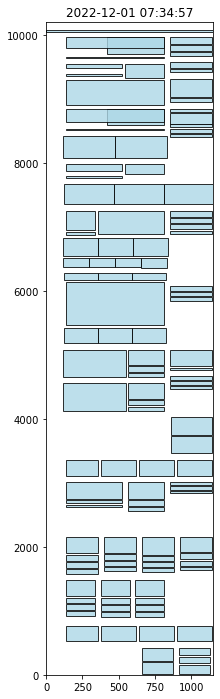

In [729]:
bb.plot_bounding_box_df(latimes_bounding_boxes[10], clip_right=True, figsize=(3,12))

In [ ]:
squeezed_latimes_bbs = bb.resize_all_bb_df_by_bands_end_to_end(latimes_bounding_boxes)

(1152.0, 10082.195749314531, 1280, 10840)

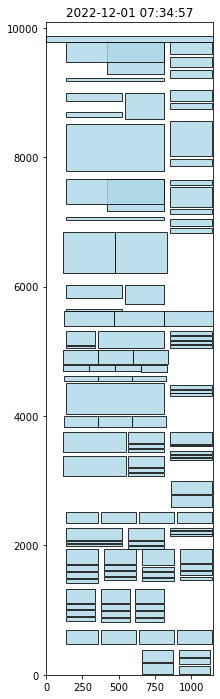

In [702]:
bb.plot_bounding_box_df(squeezed_latimes_bbs[10], clip_right=True, figsize=(3,12))

In [65]:
wayback_scrape_dir = '../data/web-archive-latimes-singlefile/tmp-latimes/web.archive.org'
latimes_files = glob.glob(
    wayback_scrape_dir + '/web/*[!_]/latimes.com/*'
)

latimes_files = sorted(latimes_files, key=lambda x: x.split('/')[-3])
# bounding_box_dfs, all_height_width = await bb.get_bounding_boxes_for_files(
#     nyt_files, here=here, headless=True
# )

In [291]:
page, browser, playwright = await bb.instantiate_new_page_object(headless=False)

/Users/spangher/Projects/usc-research/newsworthiness/notebooks/../scripts/get_bounding_boxes_from_html.py:480: RuntimeWarning: coroutine 'Browser.new_context' was never awaited
  browser.new_context(screen={'width': 860, 'height': 2040})


In [ ]:
one_file = latimes_files[0]
fp = os.path.join(here, one_file)
file = f'file://{fp}'

await page.goto(file, timeout=0)

In [294]:
latimes_bounding_boxes, _ = await bb.get_bounding_boxes_for_files(latimes_files)

  0%|          | 0/5 [00:00<?, ?it/s]

(1152.0, 10057.203125, 1280, 10701)

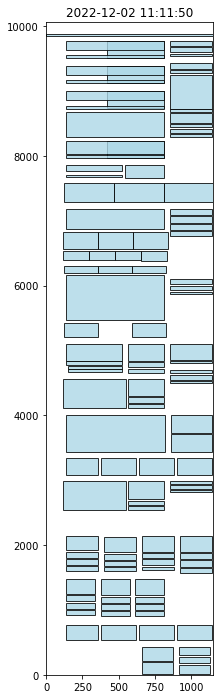

In [295]:
bb.plot_bounding_box_df(latimes_bounding_boxes[0], clip_right=True, figsize=(3,12))

In [307]:
proj_dir = '/Users/spangher/Projects/usc-research/newsworthiness'

In [309]:
ls ../scripts/index.html

../scripts/index.html


In [312]:
await page.goto(f'file://{proj_dir}/scripts/index.html')

<Response url='file:///Users/spangher/Projects/usc-research/newsworthiness/scripts/index.html' request=<Request url='file:///Users/spangher/Projects/usc-research/newsworthiness/scripts/index.html' method='GET'>>

In [3]:
async def get_browser_and_page(headless, scraping_approach):
    p = await async_playwright().start()
    browser = await p.chromium.launch(
        channel="chrome",
        headless=headless,
    )
    context = await browser.new_context(
        screen={'width': 860, 'height': 2040},
        user_agent=s.USER_AGENT
    )
    page = await context.new_page()
    await page.route("**/*", lambda route: route.abort() if route.request.resource_type == "image" else route.continue_())
    if scraping_approach == 'wget':
        await page.route("https://web.archive.org*/*", lambda route: route.abort())
    return browser, page

In [16]:
url = 'https://web.archive.org/web/20221201093526/latimes.com'

In [17]:
s.use_wget('latimes.com', url)

running wget on https://web.archive.org/web/20221201093526/latimes.com...
wget -U 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/109.0.0.0 Safari/537.36' --no-clobber --page-requisites --convert-links --timestamping --reject '*.css,*.js,*.ttf,*.woff2,*.woff,*.ico,*.txt,*.gif,*.jpg,*.jpeg,*.png,*.mp3,*.pdf,*.tgz,*.flv,*.avi,*.mpeg,*.iso' --ignore-tags=img --domains web.archive.org --no-parent https://web.archive.org/web/20221201093526/latimes.com -P /Users/spangher/Projects/usc-research/newsworthiness/notebooks/../scripts/tmp-latimes.com


In [18]:
file_on_disk = os.path.join(
    here, 
    '../scripts',
    'tmp-latimes.com',
    url.replace('https://', '')
)

In [49]:
browser, page = await get_browser_and_page(False, 'combined')

In [19]:
import os, shutil
file_on_disk = s.rename_files_for_playwright(file_on_disk)

In [ ]:
_ = await use_playwright_singlefile(file, page, 'test-index.html')

In [37]:
! open test-index.html

In [56]:
import typing
_ = await use_playwright_singlefile('file://' + file_on_disk, page, 'test-index.html')

hitting file:///Users/spangher/Projects/usc-research/newsworthiness/notebooks/../scripts/tmp-latimes.com/web.archive.org/web/20221201093526/latimes.com/index.html in playwright...


In [57]:
! open test-index.html

In [90]:
from pathlib import Path
import time

async def use_playwright_singlefile(url, page, output_file, scroll_to_bottom=True):
    def _read_script_from_file(filename: typing.Union[str, Path]) -> str:
        """Read and return Javascript code from a file. Convenience function."""
        ext_dir = Path('../scripts') / Path("js")
        with open(ext_dir / filename) as f:
            return f.read()

    await page.goto(url, timeout=120_000)
        
    single_file_pre_load_extensions = [
        "single-file-bootstrap.js",
        "single-file-hooks-frames.js",
        "single-file-frames.js",
    ]
    for f in single_file_pre_load_extensions:
        await page.evaluate(_read_script_from_file(f))

    await page.evaluate(_read_script_from_file("single-file.js"))
    wait_seconds = 5
    print(f'hitting {url} in playwright...')
    time.sleep(wait_seconds)

    # get singlefile
    page_content = await page.evaluate(
        """
            () => singlefile.getPageData({
                  removeHiddenElements: true,
                  removeUnusedStyles: true,
                  removeUnusedFonts: true,
                  removeImports: true,
                  blockScripts: true,
                  blockAudios: true,
                  blockVideos: true,
                  compressHTML: true,
                  removeAlternativeFonts: true,
                  removeAlternativeMedias: true,
                  removeAlternativeImages: true,
                  groupDuplicateImages: true
                });
        """
    )
    page_html_content = page_content.get("content")
    output_dir = os.path.dirname(output_file)
    if output_dir != '':
        os.makedirs(output_dir, exist_ok=True)
    with open(output_file, 'w') as f:
        f.write(page_html_content)
    return page_content

# SF Chronicle

In [189]:
ls ../data

gold-html-492893687/                 web-archive-inquirer-one-day.zip
gold-nytimes-html.zip                web-archive-inquirer-singlefile.zip
html-492893687.zip                   web-archive-one-day.zip
latimes-one-day.zip                  web-archive-two-months.zip
tmp-latimes/                         web.archive.org/
web-archive-inquirer/


In [653]:
ls ../scripts/data/tmp-sfchronicle-with-js/web.archive.org/web/

20221206012220/ 20221206015530/ 20221206023338/


In [664]:
# wayback_scrape_dir = '../scripts/data/tmp-sfchronicle.com/web.archive.org'
# wayback_scrape_dir = '../scripts/tmp-sfchronicle/web.archive.org'
# wayback_scrape_dir = '../scripts/tmp-sfchronicle.com/web.archive.org'
# wayback_scrape_dir = '../data/tmp-sfchron-combined/tmp-sfchronicle-combined/web.archive.org/'
wayback_scrape_dir = '../scripts/data/tmp-sfchronicle-sans-css/web.archive.org/'
sfchron_files = glob.glob(
    wayback_scrape_dir + '/web/*[!_]/sfchronicle.com/*'
)

sfchron_files = sorted(sfchron_files, key=lambda x: x.split('/')[-3])
# bounding_box_dfs, all_height_width = await bb.get_bounding_boxes_for_files(
#     nyt_files, here=here, headless=True
# )

In [668]:
page, browser, playwright = await bb.instantiate_new_page_object(
    headless=False, block_images=True, block_external_files=False
)

In [669]:
# for one_file in sfchron_files:
one_file = sfchron_files[0]
# one_file = '/Users/spangher/Projects/usc-research/newsworthiness/scripts/tmp-sfchronicle.com/web.archive.org/web/20221206034948/https%3A/www.sfchronicle.com/index.html'
# fp = one_file
fp = os.path.join(here, one_file)
file = f'file://{fp}'

# await page.goto(file, timeout=0)

In [ ]:
_ = await use_playwright_singlefile(file, page, 'test-index.html')

In [ ]:
! open test-index.html

# Slosh

In [8]:
imgs = await page.query_selector_all('img')
img = imgs[0]

output = {}
output['img_position'] = await img.bounding_box()
output['img_src'] = await img.evaluate('''node => node.src''')
output['img_text'] = await img.evaluate('''node=> node.alt.trim()''')

In [14]:
output['img_position']

{'x': 48, 'y': 929, 'width': 760, 'height': 507}

In [20]:
await page.goto('https://nytimes.com')

<Response url='https://www.nytimes.com/' request=<Request url='https://www.nytimes.com/' method='GET'>>

In [21]:
output_img_data = []
imgs = await page.query_selector_all('img')
for img in imgs:
    output = {}
    output['img_position'] = await img.bounding_box()
    output['img_src'] = await img.evaluate('''node => node.src''')
    output['img_text'] = await img.evaluate('''node=> node.alt.trim()''')
    output_img_data.append(output)

In [24]:
await img.bounding_box()

{'x': 1149.6875, 'y': 8233.09375, 'width': 90.3125, 'height': 0}